In [1]:
import segmentation_models_pytorch as smp
import torch

checkpoint_1 = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt"
)
checkpoint_2 = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/diff_batch/model-UNetPlusPlus_adam_b32.ckpt"
)
checkpoint_3 = torch.load(
    "/home/emilia/WaterSegNet/checkpoints/diff_batch/model-UNetPlusPlus_adam_b8.ckpt"
)

state_dict_1 = checkpoint_1["state_dict"]
state_dict_2 = checkpoint_2["state_dict"]
state_dict_3 = checkpoint_3["state_dict"]


model_1 = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
model_2 = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
model_3 = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)
model_1.load_state_dict(state_dict_1)

model_2.to(device)
model_2.load_state_dict(state_dict_2)

model_3.to(device)
model_3.load_state_dict(state_dict_3)

/home/emilia/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

/home/emilia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


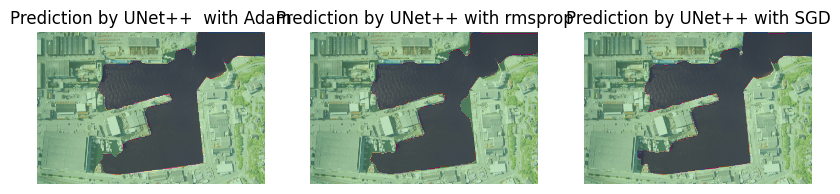

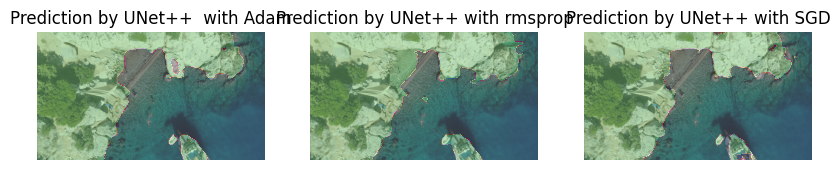

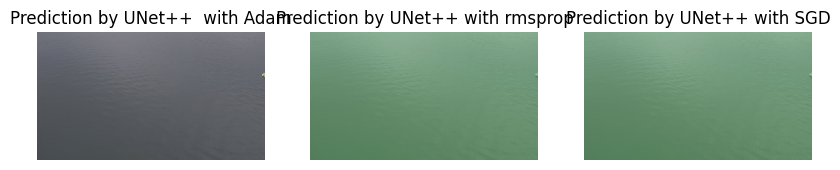

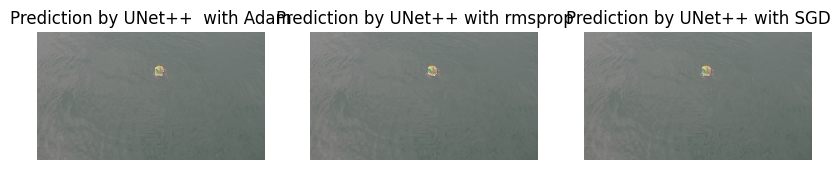

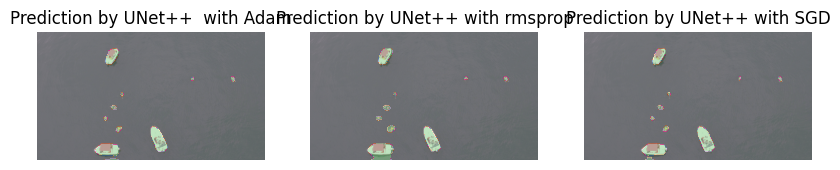

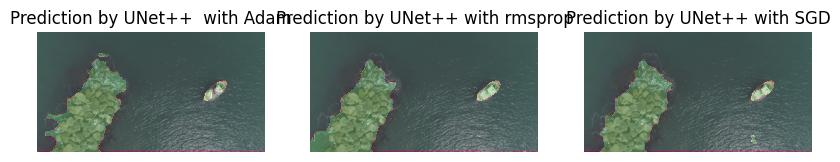

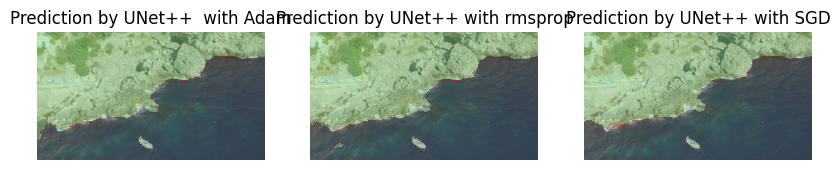

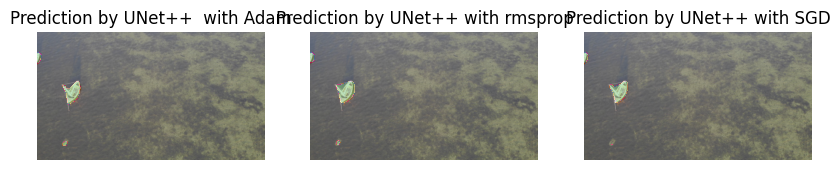

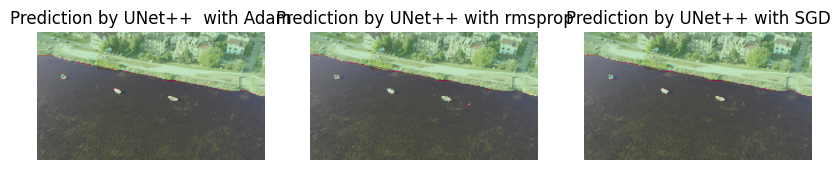

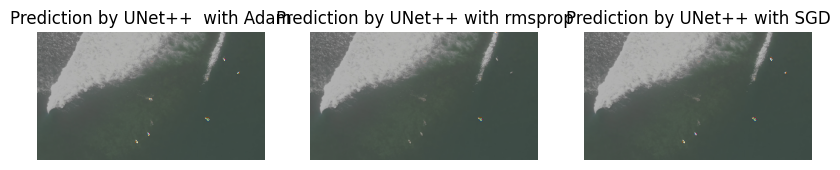

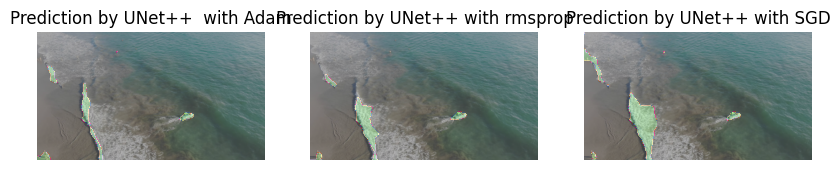

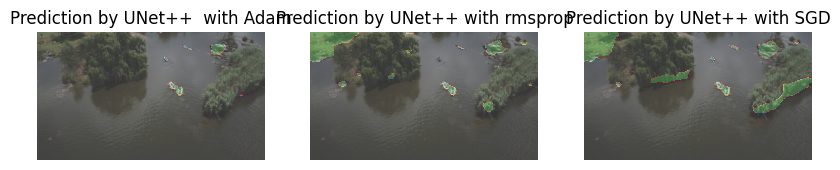

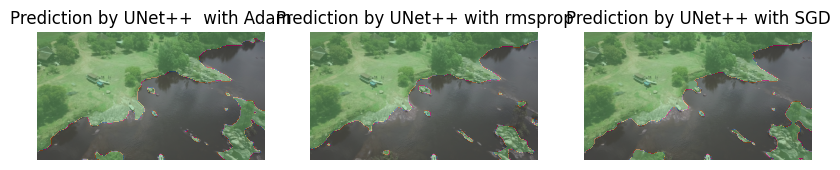

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lib.dataloader import SegDataset


def remove_border(mask, original_size):
    h, w = mask.shape
    orig_h, orig_w = original_size
    delta_w = w - orig_w
    delta_h = h - orig_h

    if delta_w > 0:
        mask = mask[:, delta_w // 2 : -delta_w // 2]
    if delta_h > 0:
        mask = mask[delta_h // 2 : -delta_h // 2, :]
    return mask


def predict_image(model, image, device):
    model.eval()
    img = torch.from_numpy(SegDataset.preprocess(image, is_mask=False))
    img = img.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(img).cpu()
        max_dim = max(image.size)
        pred = F.interpolate(pred, size=(max_dim, max_dim))
        mask = torch.sigmoid(pred) > 0.5

    mask_np = mask[0].long().squeeze().numpy()
    mask_np = remove_border(mask_np, original_size=(image.size[1], image.size[0]))
    return mask_np


def plot_predictions(image_raw, model_1, model_2, model_3, device):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_raw)
    mask = predict_image(model_1, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Prediction by UNet++  with Adam")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(image_raw)
    mask = predict_image(model_2, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Prediction by UNet++ with rmsprop")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image_raw)
    mask = predict_image(model_3, image_raw, device)
    plt.imshow(mask, alpha=0.5, cmap="Accent")
    plt.title("Prediction by UNet++ with SGD")
    plt.axis("off")


image = Image.open("/home/emilia/WaterSegNet/test/trondheim.jpg")
plot_predictions(image, model_1, model_2, model_3, device)

for i in range(1, 13):
    image_raw = Image.open("/home/emilia/WaterSegNet/test/" + str(i) + ".jpg")
    plot_predictions(image_raw, model_1, model_2, model_3, device)